In [1]:
import arviz as az
import bambi as bmb
import numpy as np
import pandas as pd
import pymc as pm

In [2]:
data = pd.read_csv("tests/data/inhaler.csv")
data["rating"] = pd.Categorical(data["rating"], categories=[1, 2, 3, 4])
data.head()

,subject,rating,treat,period,carry
0,1,1,0.5,0.5,0
1,2,1,0.5,0.5,0
2,3,1,0.5,0.5,0
3,4,1,0.5,0.5,0
4,5,1,0.5,0.5,0


In [3]:
model = bmb.Model("rating ~ period + carry + treat", data, family="cumulative")
model

/home/tomas/Desktop/bambinos/bambi/bambi/formula.py:102: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")


       Formula: rating ~ period + carry + treat
        Family: cumulative
          Link: p = logit
  Observations: 572
        Priors: 
    target = p
        Common-level effects
            period ~ Normal(mu: 0.0, sigma: 5.0)
            carry ~ Normal(mu: 0.0, sigma: 3.5356)
            treat ~ Normal(mu: 0.0, sigma: 5.0)
        
        Auxiliary parameters
            rating_threshold ~ Normal(mu: [-2.  0.  2.], sigma: 1.0, transform: ordered)

In [4]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rating_threshold, period, carry, treat]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [5]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period,0.182,0.175,-0.152,0.491,0.004,0.003,2207.0,1437.0,1.0
carry,-0.221,0.176,-0.551,0.115,0.004,0.003,1786.0,1546.0,1.0
treat,-0.777,0.248,-1.268,-0.329,0.006,0.004,1835.0,1386.0,1.0
rating_threshold[0],0.501,0.091,0.344,0.676,0.002,0.001,2190.0,1583.0,1.0
rating_threshold[1],3.031,0.189,2.674,3.380,0.004,0.003,2653.0,1705.0,1.0
rating_threshold[2],4.238,0.335,3.625,4.861,0.006,0.005,2680.0,1892.0,1.0


In [6]:
model.predict(idata)

In [7]:
idata.posterior

<xarray.Dataset>
Dimensions:               (chain: 2, draw: 1000, rating_threshold_dim: 3,
                           rating_obs: 572, rating_dim: 4)
Coordinates:
  * chain                 (chain) int64 0 1
  * draw                  (draw) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * rating_threshold_dim  (rating_threshold_dim) int64 0 1 2
  * rating_obs            (rating_obs) int64 0 1 2 3 4 5 ... 567 568 569 570 571
  * rating_dim            (rating_dim) <U1 '1' '2' '3' '4'
Data variables:
    period                (chain, draw) float64 0.3231 0.3155 ... 0.3384
    carry                 (chain, draw) float64 -0.06838 -0.004207 ... -0.227
    treat                 (chain, draw) float64 -1.093 -1.266 ... -0.7212
    rating_threshold      (chain, draw, rating_threshold_dim) float64 0.5044 ...
    rating_mean           (chain, draw, rating_obs, rating_dim) float64 0.708...
Attributes:
    created_at:                  2023-05-27T17:41:35.689536
    arviz_version:               0.14.0
    inference_library:           pymc
    inference_library_version:   5.4.0
    sampling_time:               9.781342506408691
    tuning_steps:                1000
    modeling_interface:          bambi
    modeling_interface_version:  0.12.0.dev

In [8]:
idata.posterior["rating_mean"].sum("rating_dim")

<xarray.DataArray 'rating_mean' (chain: 2, draw: 1000, rating_obs: 572)>
array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]])
Coordinates:
  * chain       (chain) int64 0 1
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * rating_obs  (rating_obs) int64 0 1 2 3 4 5 6 ... 565 566 567 568 569 570 571

In [9]:
model.predict(idata, kind="pps")

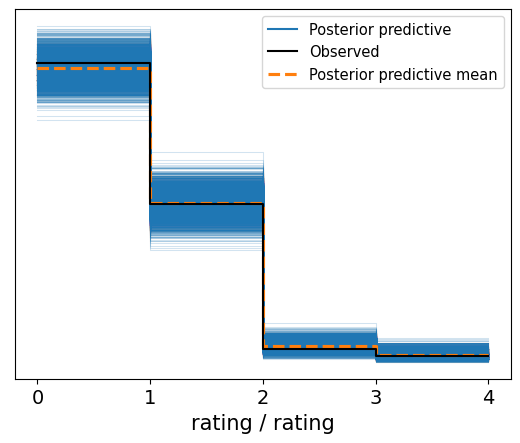

In [10]:
az.plot_ppc(idata);

**WORKS!!!**

In [14]:
priors = {
    "threshold": bmb.Prior("Normal", mu=[-0.5, 0, 0.5], sigma=1.5, transform=pm.distributions.transforms.univariate_ordered)
}
model = bmb.Model("rating ~ period + carry + treat", data, family="cumulative", priors=priors)
model

/home/tomas/Desktop/bambinos/bambi/bambi/formula.py:102: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")


       Formula: rating ~ period + carry + treat
        Family: cumulative
          Link: p = logit
  Observations: 572
        Priors: 
    target = p
        Common-level effects
            period ~ Normal(mu: 0.0, sigma: 5.0)
            carry ~ Normal(mu: 0.0, sigma: 3.5356)
            treat ~ Normal(mu: 0.0, sigma: 5.0)
        
        Auxiliary parameters
            rating_threshold ~ Normal(mu: [-0.5  0.   0.5], sigma: 1.5, transform: ordered)

In [15]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rating_threshold, period, carry, treat]


In [16]:
model.predict(idata, kind="pps")

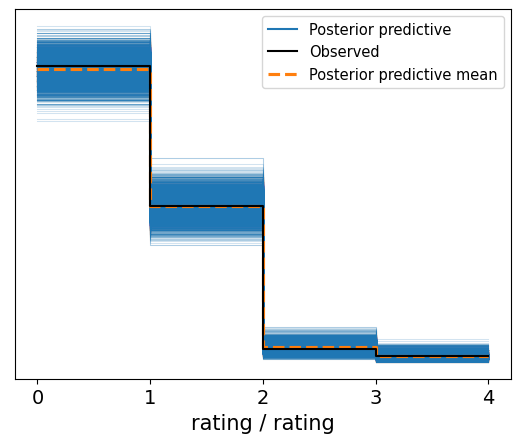

In [17]:
az.plot_ppc(idata);

---

## Stopping Ratio

In [12]:
model = bmb.Model("rating ~ period + carry + treat", data, family="sratio")
model

/home/tomas/Desktop/bambinos/bambi/bambi/formula.py:102: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")


       Formula: rating ~ period + carry + treat
        Family: sratio
          Link: p = logit
  Observations: 572
        Priors: 
    target = p
        Common-level effects
            period ~ Normal(mu: 0.0, sigma: 5.0)
            carry ~ Normal(mu: 0.0, sigma: 3.5356)
            treat ~ Normal(mu: 0.0, sigma: 5.0)
        
        Auxiliary parameters
            rating_threshold ~ Normal(mu: [-2.  0.  2.], sigma: 1.0)

In [13]:
idata = model.fit(tune=200, draws=200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rating_threshold, period, carry, treat]


Sampling 2 chains for 200 tune and 200 draw iterations (400 + 400 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [14]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rating_threshold[0],0.529,0.086,0.371,0.700,0.003,0.002,673.0,294.0,1.01
rating_threshold[1],2.190,0.206,1.792,2.563,0.010,0.007,431.0,238.0,1.00
rating_threshold[2],1.314,0.453,0.384,2.073,0.019,0.019,647.0,134.0,1.00
period,0.209,0.162,-0.119,0.506,0.008,0.007,446.0,279.0,1.01
carry,-0.193,0.165,-0.538,0.076,0.009,0.006,333.0,270.0,1.01
treat,-0.782,0.214,-1.174,-0.407,0.012,0.009,328.0,248.0,1.00


```r
Population-Level Effects: 
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept[1]     0.55      0.09     0.38     0.73 1.00     5196     3204
Intercept[2]     2.26      0.22     1.84     2.71 1.00     5275     2661
Intercept[3]     1.09      0.43     0.27     1.98 1.00     5299     2562
treat           -0.75      0.22    -1.19    -0.31 1.00     3648     2724
period           0.21      0.17    -0.12     0.53 1.00     5490     3392
carry           -0.22      0.17    -0.53     0.11 1.00     3726     2606
```

In [15]:
model.predict(idata)

In [16]:
idata.posterior["rating_mean"]

<xarray.DataArray 'rating_mean' (chain: 2, draw: 200, rating_obs: 572,
                                 rating_dim: 4)>
array([[[[6.81389832e-01, 2.88715698e-01, 2.61472706e-02,
          3.74719931e-03],
         [6.81389832e-01, 2.88715698e-01, 2.61472706e-02,
          3.74719931e-03],
         [6.81389832e-01, 2.88715698e-01, 2.61472706e-02,
          3.74719931e-03],
         ...,
         [7.24722438e-01, 2.53919963e-01, 1.91304892e-02,
          2.22710982e-03],
         [5.62594513e-01, 3.73160294e-01, 5.18822012e-02,
          1.23629917e-02],
         [7.24722438e-01, 2.53919963e-01, 1.91304892e-02,
          2.22710982e-03]],

        [[6.97272046e-01, 2.80373712e-01, 1.67921512e-02,
          5.56209107e-03],
         [6.97272046e-01, 2.80373712e-01, 1.67921512e-02,
          5.56209107e-03],
         [6.97272046e-01, 2.80373712e-01, 1.67921512e-02,
          5.56209107e-03],
...
         [7.68833963e-01, 2.20092534e-01, 9.48330528e-03,
          1.59019774e-03],
         [5.86581825e-01, 3.69804615e-01, 3.13076983e-02,
          1.23058619e-02],
         [7.68833963e-01, 2.20092534e-01, 9.48330528e-03,
          1.59019774e-03]],

        [[7.33370728e-01, 2.54519234e-01, 1.09736046e-02,
          1.13643304e-03],
         [7.33370728e-01, 2.54519234e-01, 1.09736046e-02,
          1.13643304e-03],
         [7.33370728e-01, 2.54519234e-01, 1.09736046e-02,
          1.13643304e-03],
         ...,
         [7.89405751e-01, 2.03489814e-01, 6.60269578e-03,
          5.01738926e-04],
         [5.34237823e-01, 4.18062895e-01, 3.82102877e-02,
          9.48899419e-03],
         [7.89405751e-01, 2.03489814e-01, 6.60269578e-03,
          5.01738926e-04]]]])
Coordinates:
  * chain       (chain) int64 0 1
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198 199
  * rating_obs  (rating_obs) int64 0 1 2 3 4 5 6 ... 565 566 567 568 569 570 571
  * rating_dim  (rating_dim) <U1 '1' '2' '3' '4'

In [17]:
idata.posterior["rating_mean"].sum("rating_dim")

<xarray.DataArray 'rating_mean' (chain: 2, draw: 200, rating_obs: 572)>
array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]])
Coordinates:
  * chain       (chain) int64 0 1
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198 199
  * rating_obs  (rating_obs) int64 0 1 2 3 4 5 6 ... 565 566 567 568 569 570 571

In [18]:
model.predict(idata, kind="pps")

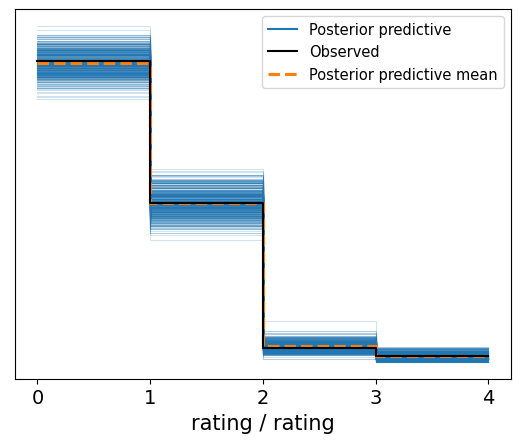

In [19]:
az.plot_ppc(idata);

**WORKS!**

---

In [20]:
df_stemcell = pd.read_csv("stemcell.csv")

In [21]:
df_stemcell.head()

,belief,rating,gender
0,fundamentalist,1,female
1,fundamentalist,1,female
2,fundamentalist,1,female
3,fundamentalist,1,female
4,fundamentalist,1,female


In [22]:
df_stemcell["rating"] = np.abs(df_stemcell["rating"] - 5)
df_stemcell["belief"] = pd.Categorical(df_stemcell["belief"], categories=["moderate", "fundamentalist", "liberal"], ordered=True)
df_stemcell["rating"] = pd.Categorical(df_stemcell["rating"], categories=[4, 3, 2, 1])

In [27]:
bmb_stemcell = bmb.Model("rating ~ 1 + belief", df_stemcell, family="cumulative", link="probit")
bmb_stemcell

/home/tomas/Desktop/bambinos/bambi/bambi/formula.py:102: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")


       Formula: rating ~ 1 + belief
        Family: cumulative
          Link: p = probit
  Observations: 829
        Priors: 
    target = p
        Common-level effects
            belief ~ Normal(mu: [0. 0.], sigma: [5.345  5.2462])
        
        Auxiliary parameters
            rating_threshold ~ Normal(mu: [-2.  0.  2.], sigma: 1.0, transform: ordered)

In [28]:
idata = bmb_stemcell.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rating_threshold, belief]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [29]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
belief[fundamentalist],-0.238,0.095,-0.403,-0.039,0.003,0.002,1182.0,1462.0,1.0
belief[liberal],0.322,0.098,0.152,0.519,0.003,0.002,1402.0,1290.0,1.0
rating_threshold[0],-1.255,0.083,-1.412,-1.102,0.003,0.002,980.0,1204.0,1.0
rating_threshold[1],-0.632,0.071,-0.760,-0.497,0.002,0.001,1267.0,1304.0,1.0
rating_threshold[2],0.582,0.072,0.437,0.710,0.002,0.001,1428.0,1569.0,1.0


---

In [27]:
df_marriage = pd.read_csv("marriage.csv")
print(df_marriage.shape)
df_marriage.head()

(1228, 5)


,ID,together,age,years,divorced
0,1,yes,19,9,True
1,2,yes,22,9,False
2,3,yes,20,5,False
3,4,yes,22,2,False
4,5,yes,25,6,False


In [28]:
df_marriage = df_marriage[df_marriage.divorced == True].reset_index(drop=True)

In [29]:
df_marriage.shape

(616, 5)

In [30]:
np.sort(df_marriage["years"].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 23, 24, 27])

In [31]:
df_marriage["years"] = pd.Categorical(df_marriage["years"], categories=np.arange(27) + 1)

In [32]:
priors = {
    "threshold": bmb.Prior("Normal", mu=0, sigma=5),
    "age": bmb.Prior("Normal", mu=0, sigma=5),
    "together": bmb.Prior("Normal", mu=0, sigma=5)
}


bmb_marriage = bmb.Model(
    "years ~ 1 + age + together", df_marriage, family="sratio", link="cloglog", priors=priors
)
bmb_marriage

/home/tomas/Desktop/bambinos/bambi/bambi/formula.py:102: UserWarning: The intercept is omitted in ordinal families
  warnings.warn("The intercept is omitted in ordinal families")


       Formula: years ~ 1 + age + together
        Family: sratio
          Link: p = cloglog
  Observations: 616
        Priors: 
    target = p
        Common-level effects
            age ~ Normal(mu: 0.0, sigma: 5.0)
            together ~ Normal(mu: 0.0, sigma: 5.0)
        
        Auxiliary parameters
            years_threshold ~ Normal(mu: 0.0, sigma: 5.0)

In [33]:
idata = bmb_marriage.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [years_threshold, age, together]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 394 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [34]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
years_threshold[0],-3.330,0.271,-3.855,-2.833,0.016,0.011,291.0,641.0,1.01
years_threshold[1],-2.978,0.262,-3.484,-2.512,0.016,0.011,267.0,613.0,1.01
years_threshold[2],-2.886,0.266,-3.376,-2.382,0.016,0.011,270.0,559.0,1.01
years_threshold[3],-2.893,0.274,-3.389,-2.363,0.017,0.012,265.0,573.0,1.01
years_threshold[4],-2.657,0.268,-3.182,-2.179,0.017,0.012,264.0,574.0,1.01
years_threshold[5],-2.259,0.260,-2.707,-1.723,0.016,0.012,251.0,485.0,1.01
years_threshold[6],-2.335,0.268,-2.840,-1.838,0.016,0.011,279.0,595.0,1.01
years_threshold[7],-2.462,0.278,-2.948,-1.919,0.016,0.011,308.0,676.0,1.01
years_threshold[8],-2.510,0.294,-3.054,-1.973,0.016,0.011,333.0,570.0,1.01
years_threshold[9],-2.081,0.277,-2.600,-1.576,0.016,0.011,305.0,685.0,1.01


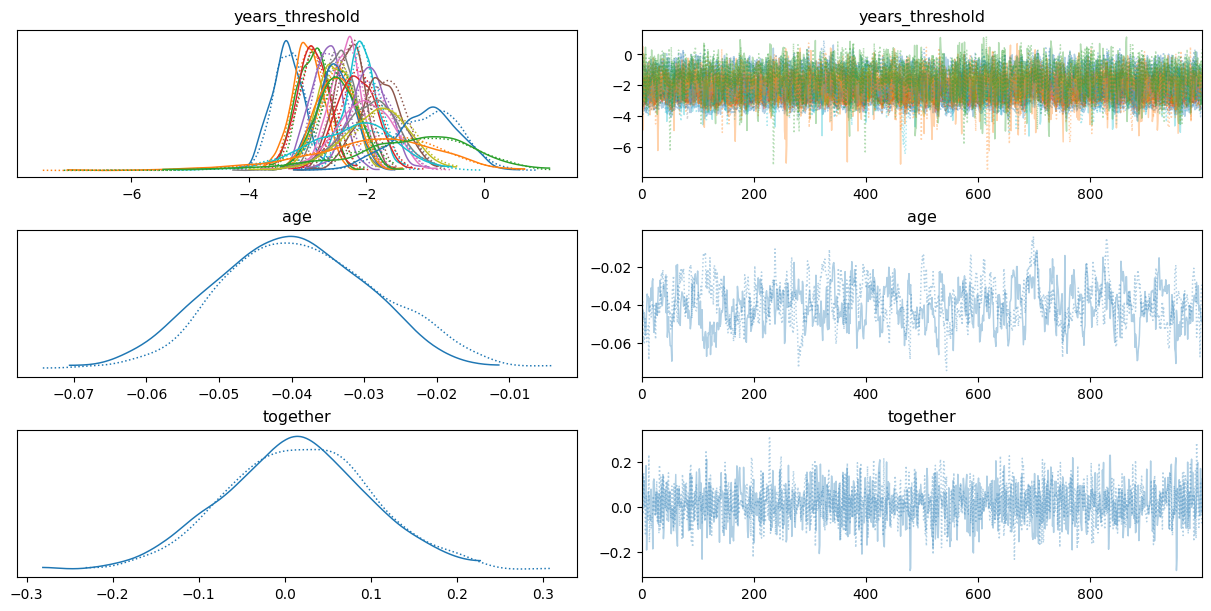

In [35]:
az.plot_trace(idata, backend_kwargs={"layout": "constrained"});

# To Do

* Implement tests